In [1]:
import numpy as np
import matplotlib.pyplot as plt

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [2]:
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=10):
  x = np.linspace(0, 1, num=n)
  #-2*x**3 + 3*x**2
  return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts):
  # the straight-line may be along x or y axis
  x0, y0, t0 = curr_pose
  xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
  x = (xf - x0) * np.linspace(0, 1, n) + x0
  y = (yf - y0) * np.linspace(0, 1, n) + y0
  return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
  # adjust scaling constant for desired turn radius
  x0, y0, t0 = curr_pose
  theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
  x= x0 + np.cumsum(v*np.cos(theta)*dt)
  y= y0 + np.cumsum(v*np.sin(theta)*dt)
  return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
  curr_pose = init_pose
  func = {'straight': straight, 'turn': turn}
  x, y, t = np.array([]), np.array([]),np.array([])
  for manoeuvre, command in route:
    px, py, pt = func[manoeuvre](command, curr_pose)
    curr_pose = px[-1],py[-1],pt[-1]  # New current pose
    x = np.concatenate([x, px])
    y = np.concatenate([y, py])
    t = np.concatenate([t, pt])
        
  return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

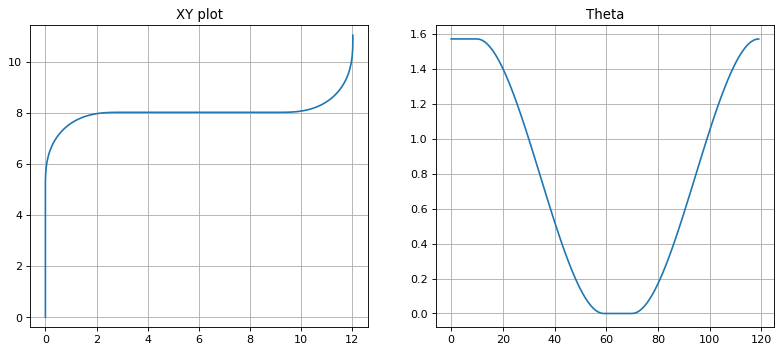

In [3]:
route = [
    ("straight", 5),
    ("turn", -90),
    ("straight", 6),
    ("turn", 90)
]
x, y, th = generate_trajectory(route)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.axis('equal')
plt.title("XY plot")
plt.plot(x, y)
plt.grid()
plt.subplot(1,2,2)
plt.title("Theta")
plt.plot(th)
plt.grid()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point. This is much because the $\frac{\Delta Y}{\Delta X}$ value has canged (slope).

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

Angle -90.00 at (0, 5)
Path is [('straight', 2.0), ('turn', -90.0), ('straight', 2.0)]


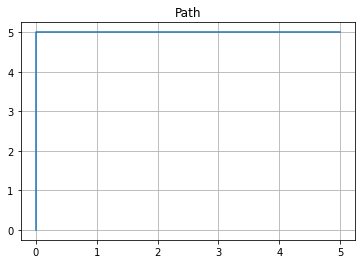

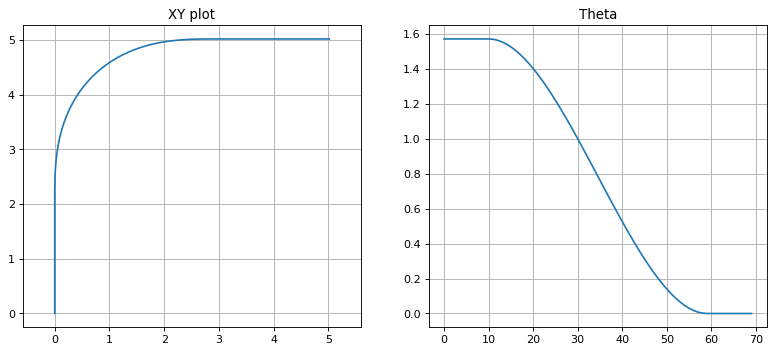

In [4]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.title("Path")
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
interest_points = [(x[0], y[0])]  # Interest points (corners + start and stop)
for i in range(1, len(x)-1, 1):
  x1, y1 = x[i-1], y[i-1]
  x2, y2 = x[i], y[i]
  x3, y3 = x[i+1], y[i+1]
  ang12 = np.arctan2(y2-y1, x2-x1)
  ang23 = np.arctan2(y3-y2, x3-x2)
  ang_rel = ang23 - ang12
  if ang_rel != 0:
    interest_points.append((x2, y2))
    print(f"Angle {np.rad2deg(ang_rel):.2f} at {(x2, y2)}")
interest_points.append((x[-1], y[-1]))

# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
turn_radius = 1
path = []
def dist(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  return ((x2-x1)**2+(y2-y1)**2)**(0.5)
# Start the main thing
turn_radius = 3 * turn_radius
path.append(("straight", dist(interest_points[0], interest_points[1]) 
                      - (0 if len(interest_points) == 2 else turn_radius)))
for i in range(1, len(interest_points)-1):
  x1, y1 = interest_points[i-1]
  x2, y2 = interest_points[i]
  x3, y3 = interest_points[i+1]
  ang = np.arctan2((y3-y2), (x3-x2)) - np.arctan2((y2-y1), (x2-x1))
  path.append(("turn", np.rad2deg(ang)))  # Add the turn
  path.append(("straight", dist((x2, y2), (x3, y3)) - turn_radius
                          - (0 if i+1 == len(interest_points)-1 else turn_radius)))

print(f"Path is {path}")

# use generate_trajectory() and plot the smooth path
x, y, th = generate_trajectory(path)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.axis('equal')
plt.title("XY plot")
plt.plot(x, y)
plt.grid()
plt.subplot(1,2,2)
plt.title("Theta")
plt.plot(th)
plt.grid()

Saving the path as a `.npy` file

In [5]:
save_path = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1), th.reshape(-1, 1)))
np.save("./data/srs_path.npy", save_path) # Save the path

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

In [6]:
!tree

.
└── data
    ├── astar_grid.npy
    └── srs_path.npy

1 directory, 2 files


Import important libraries

In [7]:
import networkx as nx

Load the grid

Loaded grid of shape (20, 20)


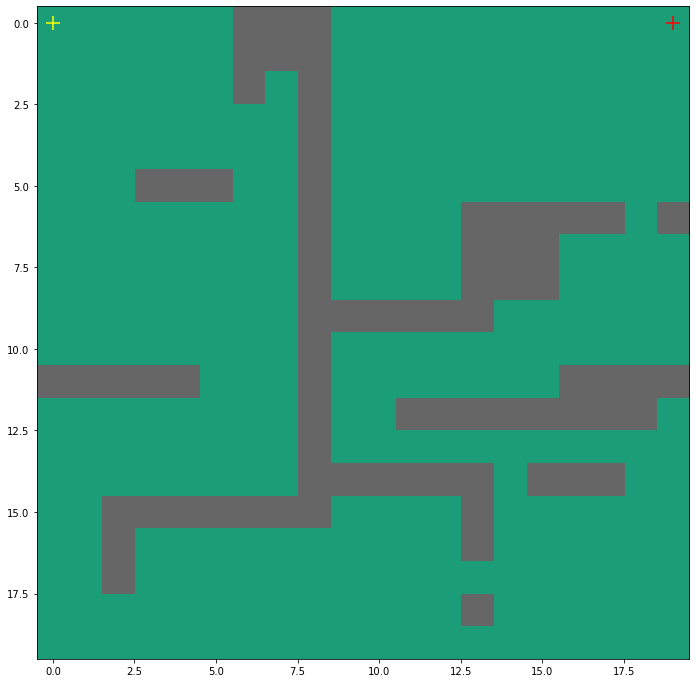

In [8]:
# Load grid
grid = np.load("./data/astar_grid.npy")
print(f"Loaded grid of shape {grid.shape}")
# you can define your own start/ end
start = (0, 0)
goal = (0, 19)
# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

Remove nodes that are occupied

Removed 77 nodes
Number of occupied cells in grid 77


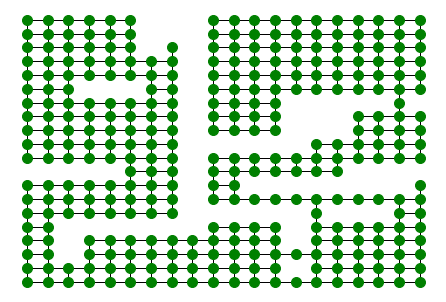

In [9]:
#initialize graph
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)
# G.nodes -> (0,0), (0,1), ... (19, 18), (19, 19)
num_nodes = 0 # counter to keep track of deleted nodes
#nested loop to remove nodes that are not connected
#free cell => grid[i, j] = 0
#occupied cell => grid[i, j] = 1
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i, j] == 1: # If occupied
      G.remove_node((i, j))
      num_nodes += 1

print(f"Removed {num_nodes} nodes")
print(f"Number of occupied cells in grid {np.sum(grid)}")
pos = {(x,y):(y,-x) for x,y in G.nodes()} # Converting axis
nx.draw(G, pos=pos, node_color='green', node_size=100)

Create an A* path

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]


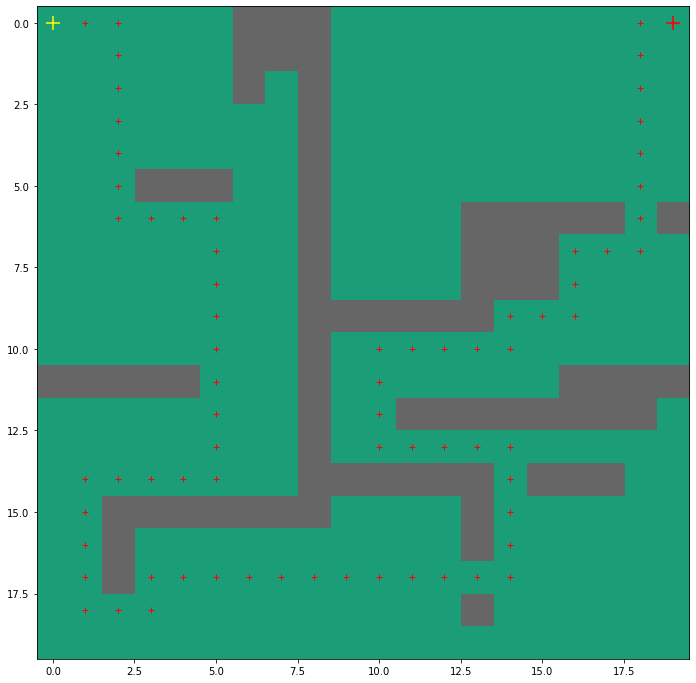

In [10]:
def euclidean(node1, node2):
  x1, y1 = node1
  x2, y2 = node2
  return ((x1-x2)**2 + (y1-y2)**2)**0.5

nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, "cost")  # All edges have cost = 1
weight = 1.0  # Weight for heuristic
astar_path = nx.astar_path(G, start, goal, 
                  heuristic=lambda n1, n2: weight * euclidean(n1, n2), 
                  weight="cost")
print(astar_path)
# Visualize the path
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')

Get the path

In [11]:
a = np.array(astar_path)
y, x = -a[:, 0], a[:, 1]

#find the corner point and plot it
interest_points = [(x[0], y[0])]  # Interest points (corners + start and stop)
for i in range(1, len(x)-1, 1):
  x1, y1 = x[i-1], y[i-1]
  x2, y2 = x[i], y[i]
  x3, y3 = x[i+1], y[i+1]
  ang12 = np.arctan2(y2-y1, x2-x1)
  ang23 = np.arctan2(y3-y2, x3-x2)
  ang_rel = ang23 - ang12
  if ang_rel != 0:
    if ang_rel == 3*np.pi/2:
      ang_rel = -np.pi/2
    if ang_rel == -3*np.pi/2:
      ang_rel = np.pi/2
    interest_points.append((x2, y2))
    # print(f"Angle {np.rad2deg(ang_rel):.2f} at {(x2, y2)}")
interest_points.append((x[-1], y[-1]))
# Fix a turn radius r
# Shorten the straight segments by r
# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
turn_radius = 1/3
path = []
def dist(p1, p2):
  x1, y1 = p1
  x2, y2 = p2
  return ((x2-x1)**2+(y2-y1)**2)**(0.5)
# Start the main thing
path.append(("straight", dist(interest_points[0], interest_points[1]) 
                      - (0 if len(interest_points) == 2 else turn_radius)))
for i in range(1, len(interest_points)-1):
  x1, y1 = interest_points[i-1]
  x2, y2 = interest_points[i]
  x3, y3 = interest_points[i+1]
  ang = np.arctan2((y3-y2), (x3-x2)) - np.arctan2((y2-y1), (x2-x1))
  if ang == 3 * np.pi/2:
    ang = -np.pi/2
  elif ang == -3*np.pi/2:
    ang = np.pi/2
  path.append(("turn", np.rad2deg(ang)))  # Add the turn
  path.append(("straight", dist((x2, y2), (x3, y3)) - turn_radius
                          - (0 if i+1 == len(interest_points)-1 else turn_radius)))

xi, yi = x, y # Backup
v = 1
dt = 0.01
num_st_pts = int(v/dt)
num_pts = 50
# Generate the path
x, y, th = generate_trajectory(path, (0, 0, 0))

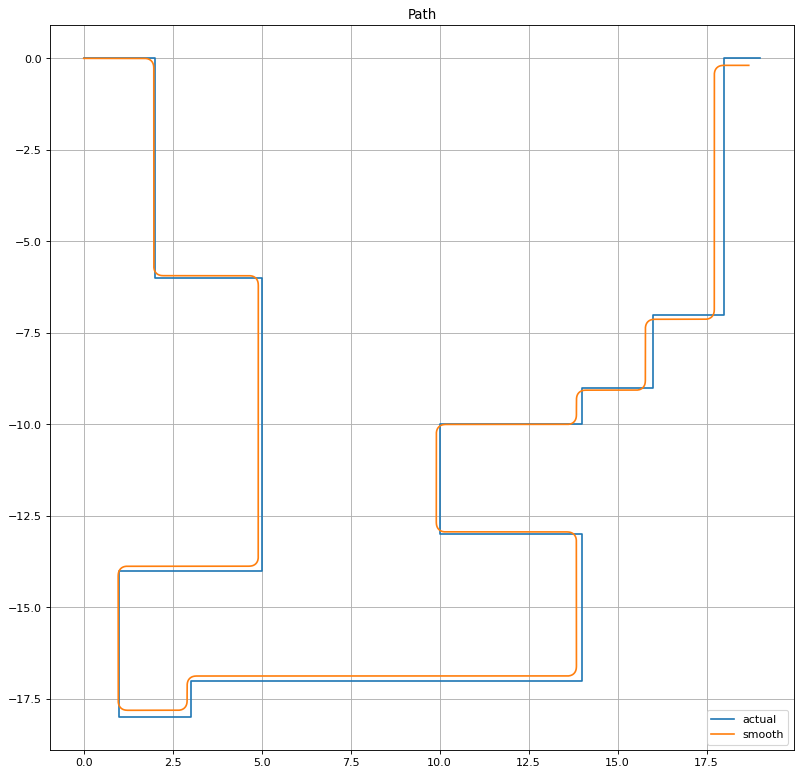

In [12]:
# Visualize the path first
plt.figure(figsize=(12, 12), dpi=80)
plt.title("Path")
plt.plot(xi, yi, label="actual")
plt.plot(x, y, label="smooth")
plt.legend()
plt.grid()

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs